# Extended Subgraph Partitioning
I will partition the input graph into several subgraphs, and then add back the surrounding nodes of each subgraph. Hopefully this will be good enough to yield a reasonable approximation.

## Example graph
First, I will develop the partitioning algorithm. My plan is to use METIS to first partition the graph while keeping track of boundary nodes. Then, I will add back the vertices (from the original graph) that are a certain distance from any boundary node.

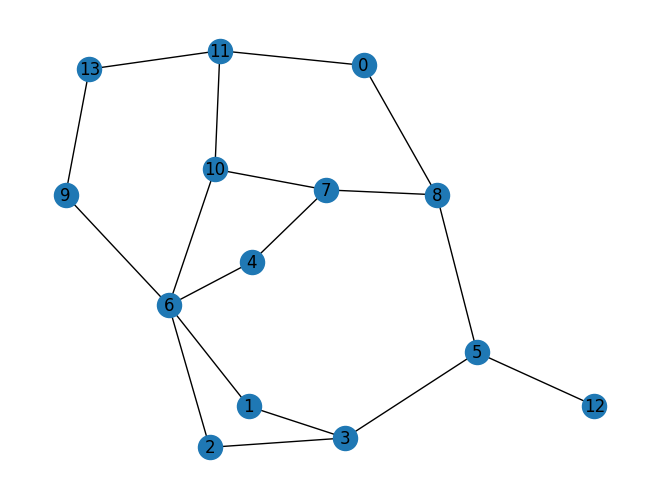

In [1]:
import networkx as nx
G = nx.Graph([(1,6),(2,6),(2,3),(6,4),(6,9),(9,13),(6,10),(4,7),(7,10),(10,11),(13,11),(11,0),(8,0),(7,8),(5,8),(3,1),(12,5),(5,3)])

layout = nx.spring_layout(G, seed=1)
nx.draw(G, pos=layout, with_labels=True)

### Partitioning with METIS

In [2]:
desired_partitions = 3

import metis

edgecuts, parts = metis.part_graph(G, desired_partitions, objtype="cut")
partition_map = {node: parts[i] for i, node in enumerate(G.nodes())}

num_partitions = len(set(parts))

/tmp/ipykernel_3904398/2054061448.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("Accent", lut=num_partitions)


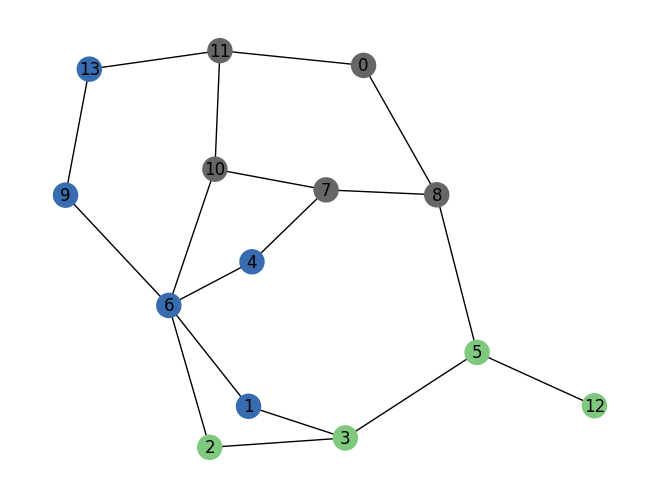

In [3]:
import matplotlib.cm as cm

colors = cm.get_cmap("Accent", lut=num_partitions)
color_map = [colors(partition_map[node]) for node in G.nodes()]
nx.draw(G, pos=layout, with_labels=True, node_color=color_map)

### Finding Boundary Edges
For each partition, I will find boundary edges of the form $(u, v)$, where $u$ is in the partition and $v$ is not. Then, I will perform BFS on all $u$ to include neighboring nodes. For some reason networkx does not provide a multisource version of the `descendants_at_distance` function, so I've written one below

In [4]:
from collections import deque

def descendants_at_distance_multisource(G, sources, distance=None):
    if sources in G:
        sources = [sources]

    queue = deque(sources)
    depths = deque([0 for _ in queue])
    visited = set(sources)

    for source in queue:
        if source not in G:
            raise nx.NetworkXError(f"The node {source} is not in the graph.")

    while queue:
        node = queue[0]
        depth = depths[0]

        if distance is not None and depth > distance: return

        yield queue[0]

        queue.popleft()
        depths.popleft()

        for child in G[node]:
            if child not in visited:
                visited.add(child)
                queue.append(child)
                depths.append(depth + 1)

Apply `descendants_at_distance_multisource` to find extended neighbors

In [5]:
# First, find indices of nodes in each partition
partitions = [set() for _ in range(num_partitions)]

for node in G.nodes():
    partitions[partition_map[node]].add(node)

# Next, find boundary nodes (vertices adjacent to vertex not in partition)
boundary_nodes = [set(map(lambda uv: uv[0], nx.edge_boundary(G, partitions[i]))) for i in range(num_partitions)]

# Perform BFS on boundary_nodes to find extended neighbors up to a certain distance
# This might include nodes in the partition as well, so for visualization purposes I subtract those already in partition
distance = 1

extended_neighbors = [set(descendants_at_distance_multisource(G, boundary_nodes[i], distance=distance)).difference(partitions[i]) for i in range(num_partitions)]
extended_neighbors

[{1, 6, 8}, {2, 3, 7, 10, 11}, {4, 5, 6, 13}]

I will draw the graph again with extended neighbors of a partition circled in its partition's respective color

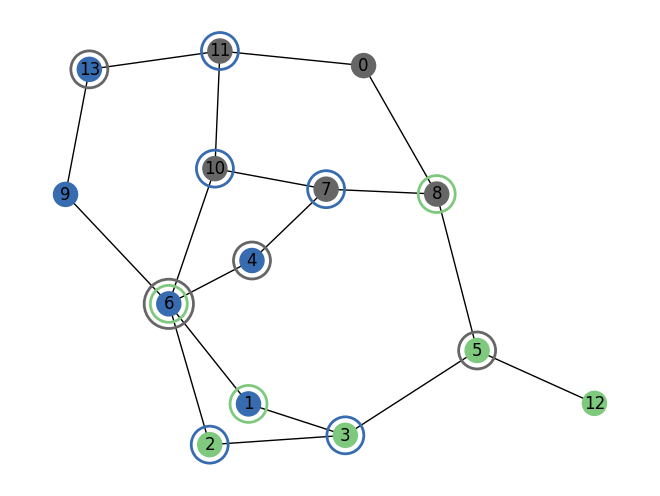

In [6]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

color_map = [colors(partition_map[node]) for node in G.nodes()]
nx.draw(G, pos=layout, with_labels=True, node_color=color_map)

radii = {node: 0.06 for node in G.nodes()}

for i, neighbors in enumerate(extended_neighbors):
    for node in neighbors:
        x, y = layout[node]
        circle = plt.Circle((x, y), radii[node], color=colors(i), fill=False, lw=2)
        plt.gca().add_patch(circle)

        radii[node] += 0.02

plt.gca().set_aspect('equal')
plt.show()

### Putting it all together
The `part_graph_extended` takes in as input:
- `G`, the graph to partition
- `desired_partitions`, the number of partitions we wish to partition the graph into
- `distance`, the maximum distance of the extended nodes which should be included in each partition

And returns a tuple `(partitions, extended_partitions)` where partitions contains the initial partitioning of the graph and extended_partitions includes the extended nodes for each partition

In [7]:
def part_graph_extended(G, desired_partitions, distance=None):
    _, parts = metis.part_graph(G, desired_partitions, objtype="cut")
    partition_map = {node: parts[i] for i, node in enumerate(G.nodes())}
    num_partitions = len(set(parts))

    # Find indices of nodes in each partition
    partitions = [set() for _ in range(num_partitions)]

    for node in G.nodes():
        partitions[partition_map[node]].add(node)

    # Find boundary nodes (vertices adjacent to vertex not in partition)
    boundary_nodes = [set(map(lambda uv: uv[0], nx.edge_boundary(G, partitions[i]))) for i in range(num_partitions)]

    # Perform BFS on boundary_nodes to find extended neighbors up to a certain distance
    extended_neighbors = [set(descendants_at_distance_multisource(G, boundary_nodes[i], distance=distance)) for i in range(num_partitions)]

    extended_partitions = [p.union(a) for p, a in zip(partitions, extended_neighbors)]

    return partitions, extended_partitions

In [8]:
part_graph_extended(G, 3, 1)

([{2, 3, 5, 12}, {1, 4, 6, 9, 13}, {0, 7, 8, 10, 11}],
 [{1, 2, 3, 5, 6, 8, 12},
  {1, 2, 3, 4, 6, 7, 9, 10, 11, 13},
  {0, 4, 5, 6, 7, 8, 10, 11, 13}])